## Import packages

In [2]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
from scipy import interpolate
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
from matplotlib.transforms import Bbox
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

### Plot of a bunch of lats to show danger of lumping latitudes together

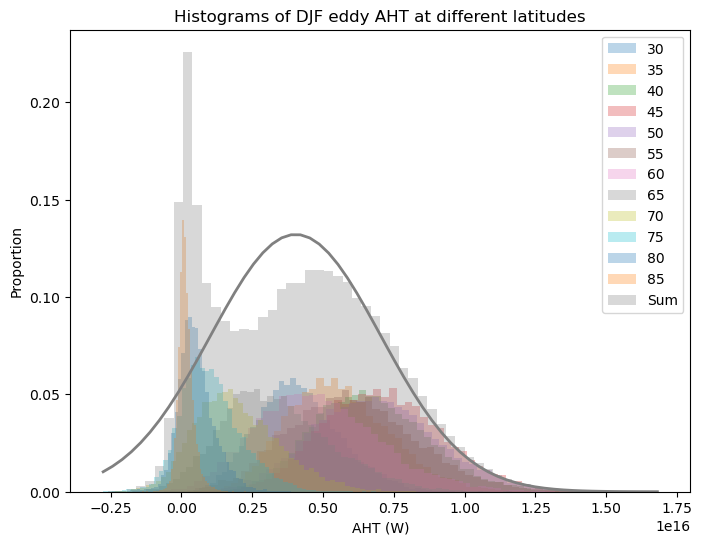

In [6]:
plt.figure(figsize=(8,6))

all_data = []

eddy_aht_season = aht_ds.eddy_aht.groupby('time.season')['DJF']
#for which_lat in range(-89, -30, 5):
for which_lat in range(30, 89, 5):
    lat_width = (geometry[era_fncts.get_lat_idx(which_lat)] * g)
    #eddy_aht = aht_ds.eddy_aht.sel(latitude=which_lat).values.flatten() / lat_width
    eddy_aht = eddy_aht_season.sel(latitude=which_lat).values.flatten()# / lat_width
    all_data.append(eddy_aht)
    plt.hist(eddy_aht, weights=np.ones(len(eddy_aht)) / len(eddy_aht), bins=60, alpha=0.3, label=str(which_lat))

all_data_values = np.array(all_data).flatten()

era_fncts.plot_hist_and_gauss(plt, all_data_values, 'grey', scale_up=3, label='Sum')
#plt.hist(all_data_values, weights=5*np.ones(len(all_data_values)) / len(all_data_values), bins=60, alpha=0.3, label='Sum')
plt.legend(loc=0)
plt.xlabel('AHT (W)')

plt.ylabel('Proportion')

plt.title('Histograms of DJF eddy AHT at different latitudes')

#plt.savefig('figures/2_8_22_meeting/eddy_aht_pdfs_n_hem_djf')

plt.show()

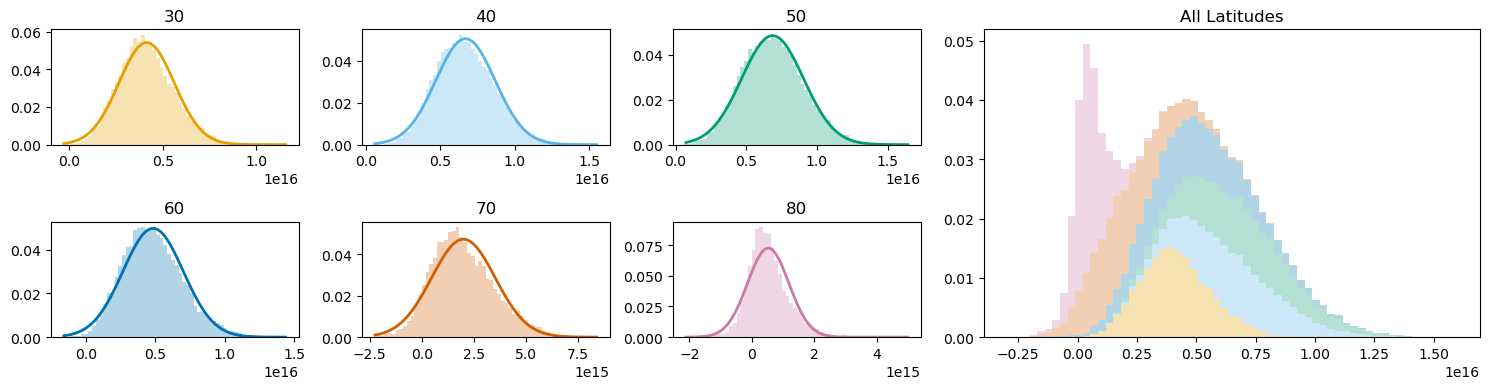

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(15,4), gridspec_kw={'width_ratios': [1, 1, 1, 2]})

all_data = []

eddy_aht_season = aht_ds.eddy_aht.groupby('time.season')['DJF']

lat_list = np.arange(30, 89, 10)

lat_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7']

lat_color_dict = dict(zip(lat_list, lat_colors))

axs_for_plots = np.delete(axs.reshape(-1), 3)[:6]
for idx, ax in enumerate(axs_for_plots):
    eddy_aht = eddy_aht_season.sel(latitude=lat_list[idx]).values.flatten()
    all_data.append(eddy_aht)
    era_fncts.plot_hist_and_gauss(ax, eddy_aht, lat_colors[idx], label=lat_list[idx])
    
    ax.set_title(lat_list[idx])
    #plt.hist(eddy_aht, weights=np.ones(len(eddy_aht)) / len(eddy_aht), bins=60, alpha=0.3, label=str(which_lat))

gs = axs[0, 3].get_gridspec()
# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

num_bins = 60

all_data = np.array(all_data)
which_bins = np.linspace(-.3e16, 1.6e16, num_bins)
# Get the mid points of every bin
bin_middles = (which_bins[1:]+which_bins[:-1])/2.
# Compute the bin-width
bin_width = which_bins[1]-which_bins[0]


probs = np.zeros(((len(lat_list)), num_bins - 1))

for i in range(len(lat_list)):

    n_bins, bin_edges = np.histogram(all_data[i,:].flatten(), which_bins)
    bin_probability = (n_bins/float(n_bins.sum())) / len(lat_list)
    probs[i,:] = bin_probability
    axbig.bar(bin_middles, bin_probability, bottom=np.sum(probs[:i,:], axis=0),
            width=bin_width, color = lat_colors[i], alpha=0.3)
    

axbig.set_title('All Latitudes')

plt.tight_layout()
#plt.savefig('figures/3_15_22_meeting/eddy_aht_pdfs_n_hem_djf_dif_lats')

plt.show()

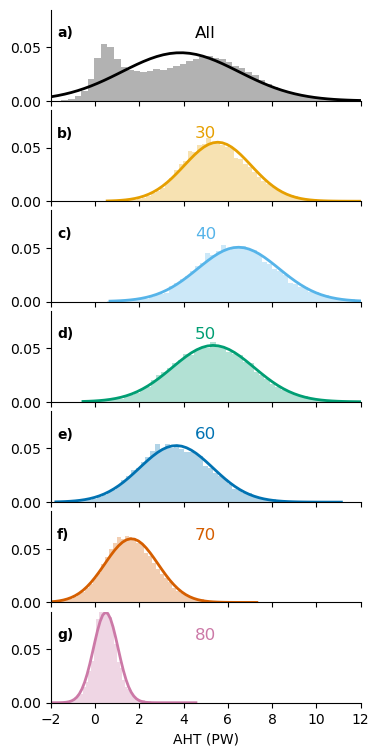

In [20]:
fig, axs = plt.subplots(7, 1, sharex=True, figsize=(4, 9))

all_data = []

eddy_aht_season = aht_ds.total_aht.groupby('time.season')['DJF']

lat_list = np.arange(30, 89, 10)
lat_list_str = lat_list.astype('str')

lat_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7']

lat_color_dict = dict(zip(lat_list, lat_colors))

ax_y_lim = [0, 0.085]
ax_x_lim = [-2, 12]

axs_for_plots = [axs[1], axs[2], axs[3], axs[4], axs[5], axs[6]]

for idx, ax in enumerate(axs_for_plots):
    eddy_aht = eddy_aht_season.sel(latitude=lat_list[idx]).values.flatten() / 1e15
    all_data.append(eddy_aht)
    era_fncts.plot_hist_and_gauss(ax, eddy_aht, lat_colors[idx], label=lat_list[idx])
    #ax.text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(eddy_aht), 2)))
    #ax.text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(eddy_aht), 2)))

era_fncts.plot_hist_and_gauss(axs[0], np.array(all_data).flatten(), 'k', label='All latitudes')    
#axs[6].text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(np.array(all_data).flatten()), 2)))
#axs[6].text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(np.array(all_data).flatten()), 2)))
    
#fig.legend(loc='upper right')

axs[6].set_xlabel('AHT (PW)')

plt.subplots_adjust(wspace=0.0, hspace=.1)

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']
for i, ax in enumerate((axs)):
    ax.patch.set_visible(False)
    ax.set_ylim(ax_y_lim)
    ax.set_xlim(ax_x_lim)
    ax.set_yticks([0, .05])
    for sp in ["top", "right"]:
        ax.spines[sp].set_visible(False)
    #ax.set_title(np.append(lat_list,'All')[i], x=0.5, y=.6, color=np.append(lat_colors, 'k')[i])
    ax.set_title(np.insert(lat_list_str, 0, 'All')[i], x=0.5, y=.6, color=np.insert(lat_colors, 0, 'k')[i])
    
    ax.text(x=0.02, y=0.7, s=subplot_labels[i], transform=ax.transAxes, fontweight='bold')

#fig.savefig('../figures/4_12_22_meeting/total_aht_pdfs_n_hem_djf_dif_lats_stacked_style', dpi=1000)
#fig.savefig('../figures/4_12_22_meeting/total_aht_pdfs_n_hem_djf_dif_lats_stacked_style.eps', format='eps')      
plt.show()

### Quantitatively compare against a Gaussian

In [9]:
### Testing out some error quantification things
def standardize(array):
    array = array.flatten()
    return (array - np.mean(array)) / np.std(array)

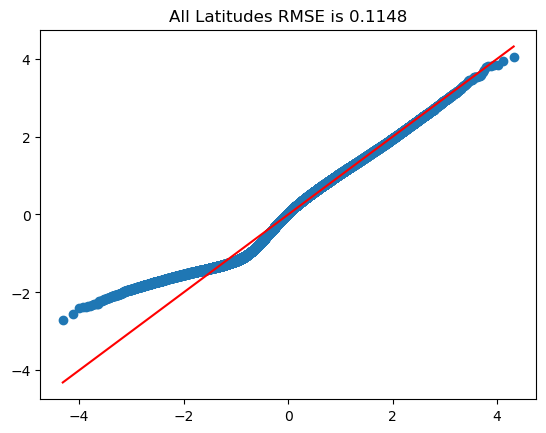

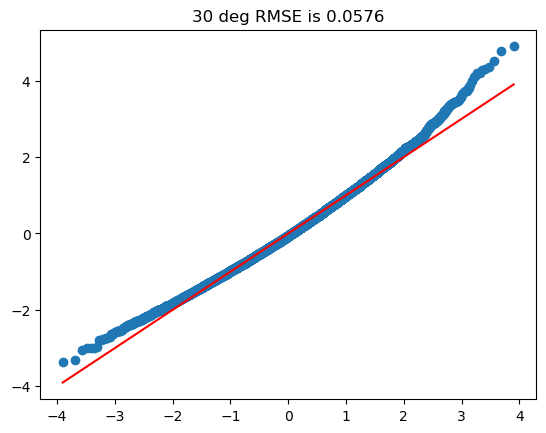

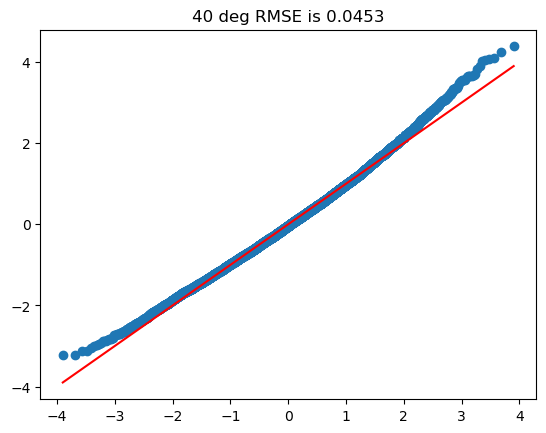

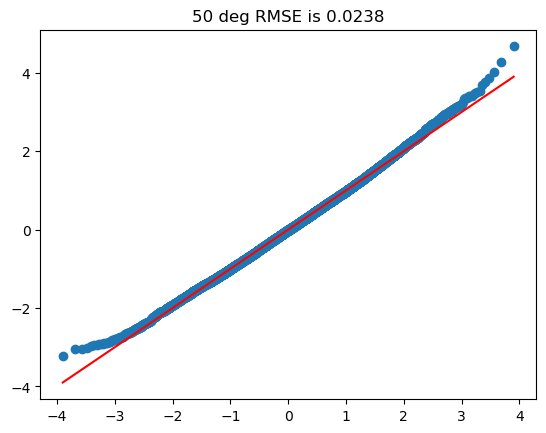

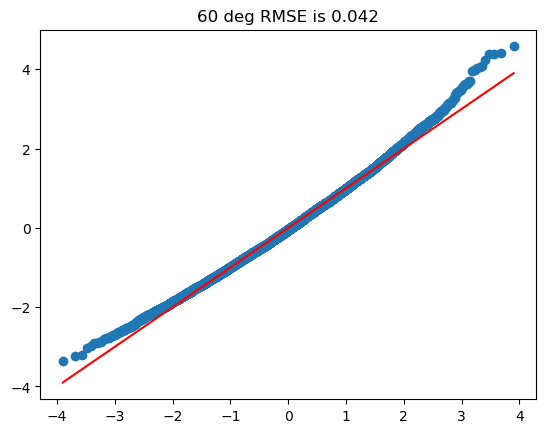

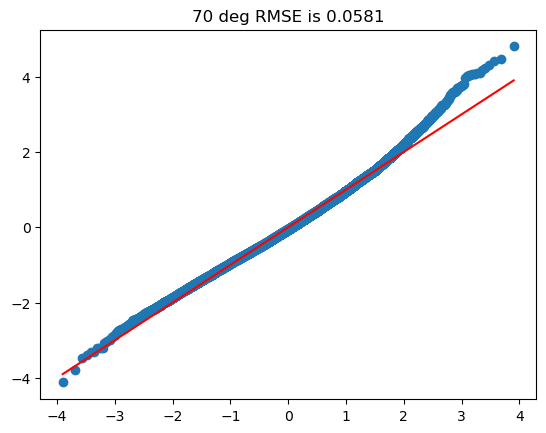

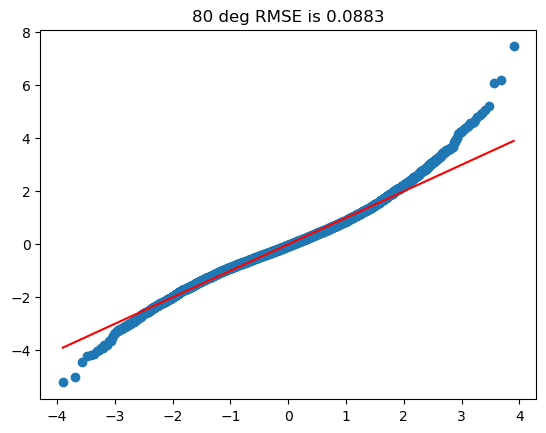

In [15]:
eddy_aht_season = aht_ds.total_aht.groupby('time.season')['DJF']


eddy_aht = eddy_aht_season.sel(latitude=lat_list).values.flatten() / 1e15

    
eddy_aht_std = standardize(eddy_aht)
    
quantiles = era_fncts.get_quantiles(eddy_aht_std)
    
plt.scatter(quantiles[0], quantiles[1])
plt.plot(quantiles[0], quantiles[0], color='r')
plt.title(f'All Latitudes RMSE is {round(quantiles[2], 4)}')
plt.show()

lat_list = np.arange(30, 89, 10)
lat_list_str = lat_list.astype('str')

rmses = []
for idx, ax in enumerate(lat_list):
    eddy_aht = eddy_aht_season.sel(latitude=lat_list[idx]).values.flatten() / 1e15
    
    eddy_aht_std = standardize(eddy_aht)
    
    quantiles = era_fncts.get_quantiles(eddy_aht_std)
    
    rmses.append(quantiles[2])
    plt.scatter(quantiles[0], quantiles[1])
    plt.plot(quantiles[0], quantiles[0], color='r')
    plt.title(f'{lat_list_str[idx]} deg RMSE is {round(quantiles[2], 4)}')
    plt.show()
    


In [17]:
np.mean(rmses)

0.05251144848697825

### Old stuff looking to quantify gaussianness

In [8]:
## FREE parameters

num_bins = 100
num_iterations = 10

In [9]:
def get_rmse(real_data, num_iterations, num_bins):

    bins = np.linspace(np.amin(real_data), np.amax(real_data), num_bins)
    bin_width = bins[1] - bins[0]
    bin_middles = (bins[1:]+bins[:-1])/2

    real_data_binned = np.histogram(real_data, bins=bins)[0]

    gaussians_binned = np.zeros((num_iterations, num_bins-1))
    
    data_mean = np.mean(real_data)
    data_std = np.std(real_data)
    
    for i in range(num_iterations):

        gaussian = np.random.normal(data_mean, data_std, len(real_data))
        gaussians_binned[i,:] = np.histogram(gaussian, bins=bins)[0]

        
    rmse_errors = ((real_data_binned[None,:] - gaussians_binned) ** 2) ** 0.5
    
    rmse_errors_mean = np.mean(rmse_errors, axis=1)
    
    rmse_cum_mean = np.cumsum(rmse_errors_mean) / range(1,num_iterations + 1)
    
    return rmse_cum_mean
    

In [10]:
eddy_30 = aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=30).values.flatten()
eddy_50 = aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=50).values.flatten()
eddy_80 = aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=80).values.flatten()
eddy_all = aht_ds.total_aht.groupby('time.season')['DJF'].values.flatten()

In [11]:
eddy_30_rmse = get_rmse(eddy_30, num_iterations, num_bins)
gaussian_30_rmse = get_rmse(np.random.normal(np.mean(eddy_30), np.std(eddy_30), len(eddy_30)),
                         num_iterations, num_bins)
eddy_50_rmse = get_rmse(eddy_50, num_iterations, num_bins)
gaussian_50_rmse = get_rmse(np.random.normal(np.mean(eddy_50), np.std(eddy_50), len(eddy_50)),
                         num_iterations, num_bins)
eddy_80_rmse = get_rmse(eddy_80, num_iterations, num_bins)
gaussian_80_rmse = get_rmse(np.random.normal(np.mean(eddy_80), np.std(eddy_80), len(eddy_80)),
                         num_iterations, num_bins)

eddy_all_rmse = get_rmse(eddy_all, num_iterations, num_bins)
gaussian_all_rmse = get_rmse(np.random.normal(np.mean(eddy_all), np.std(eddy_all), len(eddy_all)),
                         num_iterations, num_bins)

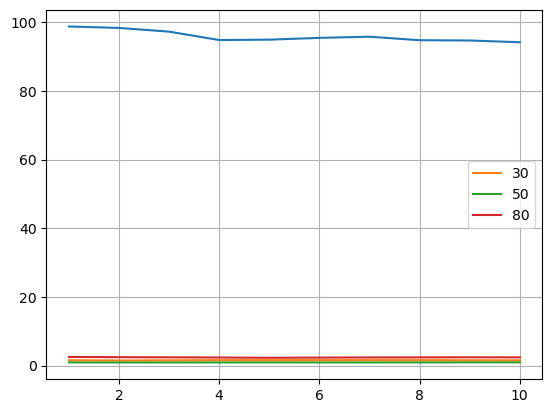

In [12]:
#plt.plot(range(1,num_iterations + 1), eddy_40_rmse)
#plt.plot(range(1,num_iterations + 1), gaussian_40_rmse)
plt.plot(range(1,num_iterations + 1), eddy_all_rmse/ gaussian_all_rmse)
plt.plot(range(1,num_iterations + 1), eddy_30_rmse/ gaussian_30_rmse, label='30')
plt.plot(range(1,num_iterations + 1), eddy_50_rmse/ gaussian_50_rmse, label='50')
plt.plot(range(1,num_iterations + 1), eddy_80_rmse/ gaussian_80_rmse, label='80')
#plt.plot(range(1,num_iterations + 1), gaussian_all_rmse)

plt.legend(loc=0)
plt.grid()
plt.show()

In [35]:
num_pts = 50
num_gaus_samples = 10

In [36]:
def get_rmse2(data, num_pts, num_gaus_samples):
    
    #Make the kernel approximation
    
    pt_evals = np.linspace(np.amin(data), np.amax(data), num_pts)
    
    kernel = sc.gaussian_kde(data, bw_method='silverman')
    kernel_data = kernel.pdf(pt_evals)
    
    kernel_scaled = kernel_data / np.sum(kernel_data)
    
    # Fit to normal distribution
    (mu, sigma) = sc.norm.fit(data)
    # The pdf should not normed anymore but scaled the same way as the data
    gaus = sc.norm.pdf(pt_evals, mu, sigma) * (pt_evals[1] - pt_evals[0])
    
    rmse_actual = np.mean(((kernel_scaled - gaus) ** 2) * (0.5))
    
    #Now make some dummy Gaussian samples to compare to
    
    rmse_gausses = np.zeros(num_gaus_samples)
    
    for i in range(num_gaus_samples):
        gaussian_data = np.random.normal(mu, sigma, len(data))

        kernel_gaus = sc.gaussian_kde(gaussian_data, bw_method='silverman')
        kernel_gaus_data = kernel_gaus.pdf(pt_evals)

        kernel_gaus_scaled = kernel_gaus_data / np.sum(kernel_gaus_data)

        rmse_gausses[i] = np.mean(((kernel_gaus_scaled - gaus) ** 2) * (0.5))
    
    return rmse_actual, rmse_gausses, pt_evals, kernel_scaled, gaus, kernel_gaus_scaled

In [37]:
aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=slice(90, 40))

<xarray.DataArray 'total_aht' (time: 14440, latitude: 101)>
[1458440 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
  * latitude  (latitude) float64 90.0 89.5 89.0 88.5 ... 41.5 41.0 40.5 40.0

In [40]:
test = get_rmse2(aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=slice(60.2, 60)).values.flatten(), num_pts, num_gaus_samples)

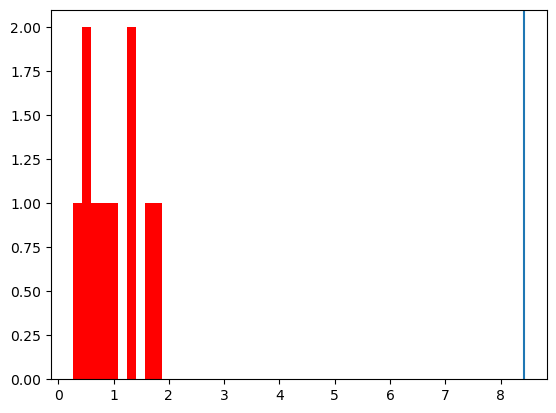

In [41]:
plt.hist(test[1] / np.mean(test[1]) ,color='r')
plt.axvline(test[0] / np.mean(test[1]))

plt.show()

1.6274283229177014e-06
[2.54209154e-07 1.11994100e-07 1.62062592e-07 3.63918718e-07
 9.47885046e-08 2.55180357e-07 1.92044541e-07 3.25920717e-07
 1.19278567e-07 5.23229199e-08]


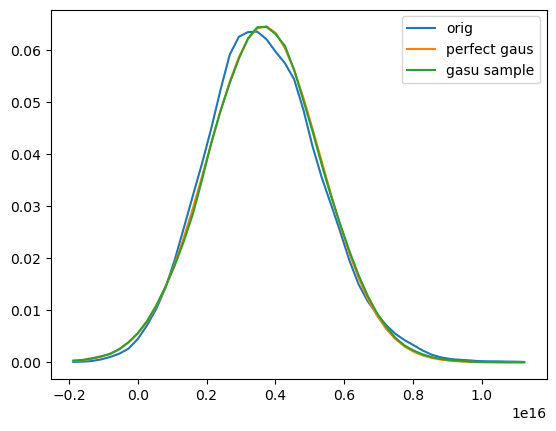

In [42]:
plt.plot(test[2], test[3], label='orig')
plt.plot(test[2], test[4], label='perfect gaus')
plt.plot(test[2], test[5], label='gasu sample')

print(test[0])
print(test[1])

plt.legend(loc=0)
plt.show()

In [ ]:
# Bin it
    #Which bins can either be an int (# of bins) or the bins themselves
    n_bins, bin_edges = np.histogram(data, which_bins) 
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n_bins/float(n_bins.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    axs.bar(bin_middles, scale_up * bin_probability, width=bin_width,
            color=which_color, alpha=0.3, label=label)

    # Fit to normal distribution
    (mu, sigma) = sc.norm.fit(data)
    # The pdf should not normed anymore but scaled the same way as the data
    gaus = sc.norm.pdf(bin_middles, mu, sigma) * bin_width
    
    if plot_gaus == True:
        axs.plot(bin_middles, gaus * scale_up, color=which_color, linewidth=2)

In [115]:
eddy_aht_test = aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=40)

bins = np.linspace(np.amin(eddy_aht_test), np.amax(eddy_aht_test), num_bins)
bin_width = bins[1] - bins[0]
bin_middles = (bins[1:]+bins[:-1])/2

eddy_binned = np.histogram(eddy_aht_test, bins=bins, density=True)[0]

In [116]:
kernel = sc.gaussian_kde(eddy_aht_test.values, bw_method='silverman')

kernel_data = kernel.pdf(bins)

In [117]:
kernel

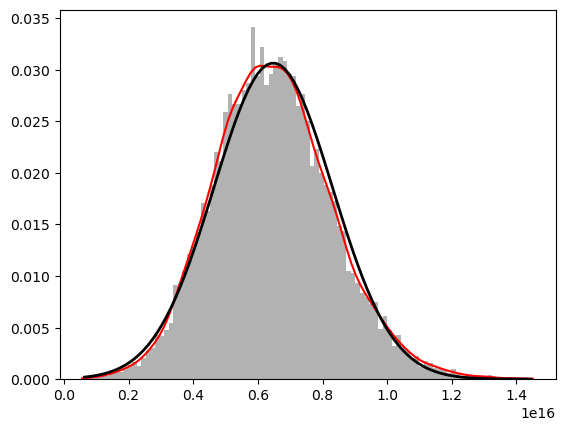

In [124]:
#plt.bar(bin_middles, eddy_binned, width=bin_width)
plt.plot(bins, kernel_data / np.sum(kernel_data), color='r')
era_fncts.plot_hist_and_gauss(plt, eddy_aht_test.values.flatten(), 'k', which_bins = bins, label='All latitudes')  
plt.show()

In [61]:
eddy_aht_test = aht_ds.total_aht.groupby('time.season')['DJF'].sel(latitude=40)

bins = np.linspace(np.amin(eddy_aht_test), np.amax(eddy_aht_test), num_bins)
bin_width = bins[1] - bins[0]
bin_middles = (bins[1:]+bins[:-1])/2

eddy_binned = np.histogram(eddy_aht_test, bins=bins)[0]

gaussians_binned = np.zeros((num_iterations, num_bins-1))
for i in range(num_iterations):
    
    gaussian = np.random.normal(eddy_aht_test.mean(), eddy_aht_test.std(), len(eddy_aht_test))
    binned = np.histogram(gaussian, bins=bins)[0]
    
    gaussians_binned[i,:] = binned

In [62]:
rmse_errors = ((eddy_binned[None,:] - gaussians_binned) ** 2) ** 0.5

In [63]:
rmse_errors_sum = np.sum(rmse_errors, axis=1)

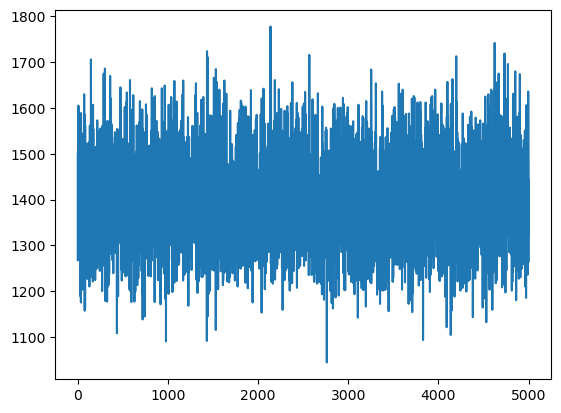

In [64]:
rmse_cum_mean = np.cumsum(rmse_errors_sum) / range(1,num_iterations + 1)

plt.plot(range(1,num_iterations + 1), rmse_errors_sum)

plt.show()

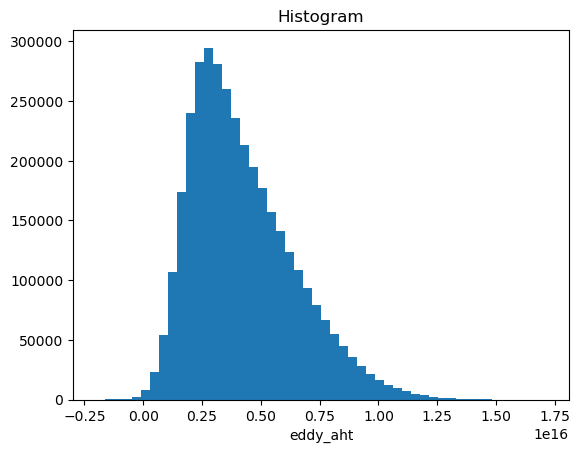

In [10]:
aht_ds.eddy_aht.sel(latitude=slice(60, 30)).plot.hist(bins=50)
plt.show()